In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# New Section

# New Section

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from google.colab import files
import io
import pandas as pd
import math 


2.2.0-rc4


In [25]:
uploaded = files.upload()

Saving WMT_data.csv to WMT_data (1).csv


In [0]:
walmart = pd.read_csv(io.BytesIO(uploaded['WMT_data.csv']))

In [27]:
walmart['close'].isnull().sum()

0

In [28]:
walmart

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT
...,...,...,...,...,...,...,...
1254,2018-02-01,105.96,106.56,105.180,105.52,6386836,WMT
1255,2018-02-02,105.15,106.47,104.150,104.48,9253068,WMT
1256,2018-02-05,103.40,104.61,97.090,100.09,12561594,WMT
1257,2018-02-06,97.64,101.08,97.250,100.90,16413797,WMT


In [0]:
walmart['ret'] = walmart.close.pct_change(1).mul(100)

In [30]:
walmart

,date,open,high,low,close,volume,Name,ret
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT,NaN
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT,-0.111919
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT,0.000000
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT,-0.014006
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT,-0.798431
...,...,...,...,...,...,...,...,...
1254,2018-02-01,105.96,106.56,105.180,105.52,6386836,WMT,-1.013133
1255,2018-02-02,105.15,106.47,104.150,104.48,9253068,WMT,-0.985595
1256,2018-02-05,103.40,104.61,97.090,100.09,12561594,WMT,-4.201761
1257,2018-02-06,97.64,101.08,97.250,100.90,16413797,WMT,0.809272


In [0]:
'''
series = walmart['close']
print(series)
type(series)
time = np.arange(0,1259,1)
print("time_shape :", time.shape)
print("series_shape :", series.shape)
'''

In [31]:
##usinng returns instead of close price
series = walmart['ret']
print(series)
type(series)
time = np.arange(0,1259,1)
print(time)


0            NaN
1      -0.111919
2       0.000000
3      -0.014006
4      -0.798431
          ...   
1254   -1.013133
1255   -0.985595
1256   -4.201761
1257    0.809272
1258    1.932607
Name: ret, Length: 1259, dtype: float64
[   0    1    2 ... 1256 1257 1258]


In [0]:

##adjusting series for using return
series = series[1:]
##slicing time for uisng wih returns
time = np.arange(0,1258,1)


In [0]:
series = pd.Series.to_numpy(series)

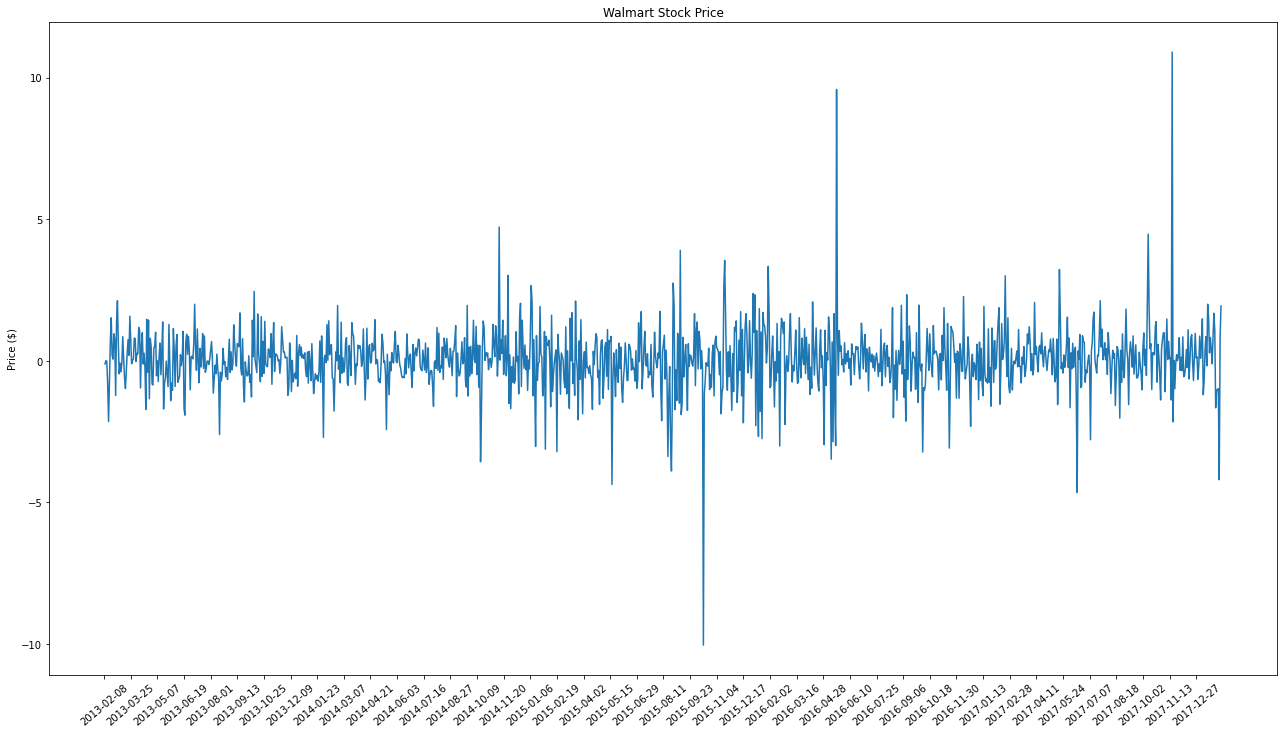

In [34]:
##plot the price
df = walmart.copy()
plt.figure(figsize = (22,12))
plt.plot(walmart.index, walmart['ret'])
plt.title('Walmart Stock Price')
plt.xticks(range(0,walmart.shape[0],30),walmart['date'].loc[::30],rotation=40)
plt.ylabel('Price ($)');
plt.show()


In [0]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 32
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
type(x_train)

numpy.ndarray

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 0s 10ms/step - loss: 5.6090 - mse: 60.2186 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 0s 10ms/step - loss: 5.5850 - mse: 59.7823 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 5.5595 - mse: 59.3223 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 5.5330 - mse: 58.8363 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 5.5053 - mse: 58.3350 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 5.4747 - mse: 57.7631 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 5.4401 - mse: 57.1022 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 0s 10ms/step - loss: 5.4029 - mse: 56.4218 - lr: 2.2387e-08
Epoch 9/100
34/34 [==============================] - 0s 10ms/step - loss: 5.3597 - mse: 55.6396 - lr

(1e-08, 0.0001, 0.0, 30.0)

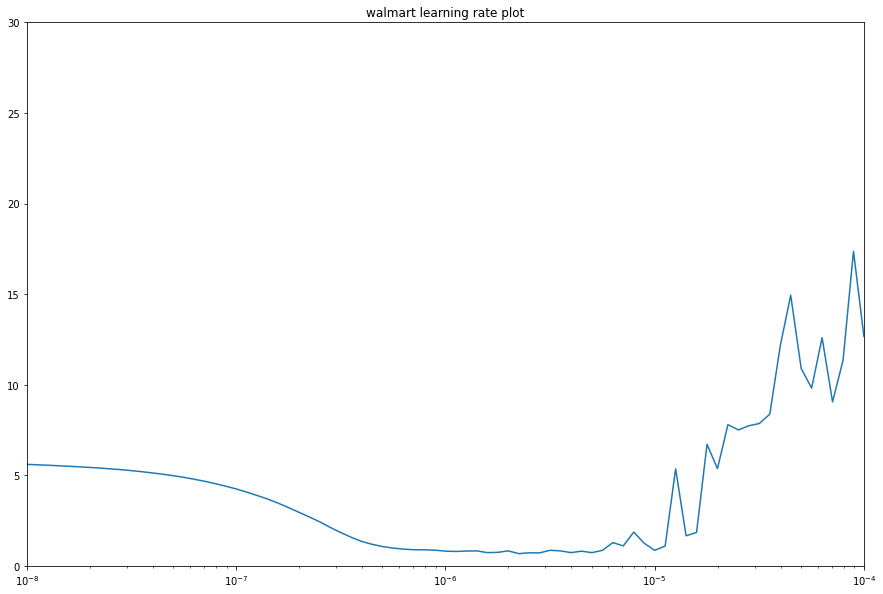

In [40]:
plt.figure(figsize=(15,10))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title("walmart learning rate plot")
plt.axis([1e-8, 1e-4, 0, 30])

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mse"])
history = model.fit(dataset,epochs=200,verbose=1)

Epoch 1/200
34/34 [==============================] - 0s 10ms/step - loss: 5.1905 - mse: 52.5333
Epoch 2/200
34/34 [==============================] - 0s 10ms/step - loss: 3.6442 - mse: 28.9346
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 2.2361 - mse: 13.4573
Epoch 4/200
34/34 [==============================] - 0s 9ms/step - loss: 1.4677 - mse: 7.2743
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 1.1221 - mse: 5.1464
Epoch 6/200
34/34 [==============================] - 0s 9ms/step - loss: 0.9498 - mse: 4.2311
Epoch 7/200
34/34 [==============================] - 0s 10ms/step - loss: 0.8850 - mse: 3.8249
Epoch 8/200
34/34 [==============================] - 0s 10ms/step - loss: 0.8514 - mse: 3.5817
Epoch 9/200
34/34 [==============================] - 0s 10ms/step - loss: 0.8157 - mse: 3.3890
Epoch 10/200
34/34 [==============================] - 0s 10ms/step - loss: 0.7973 - mse: 3.2409
Epoch 11/200
34/34 [==============================

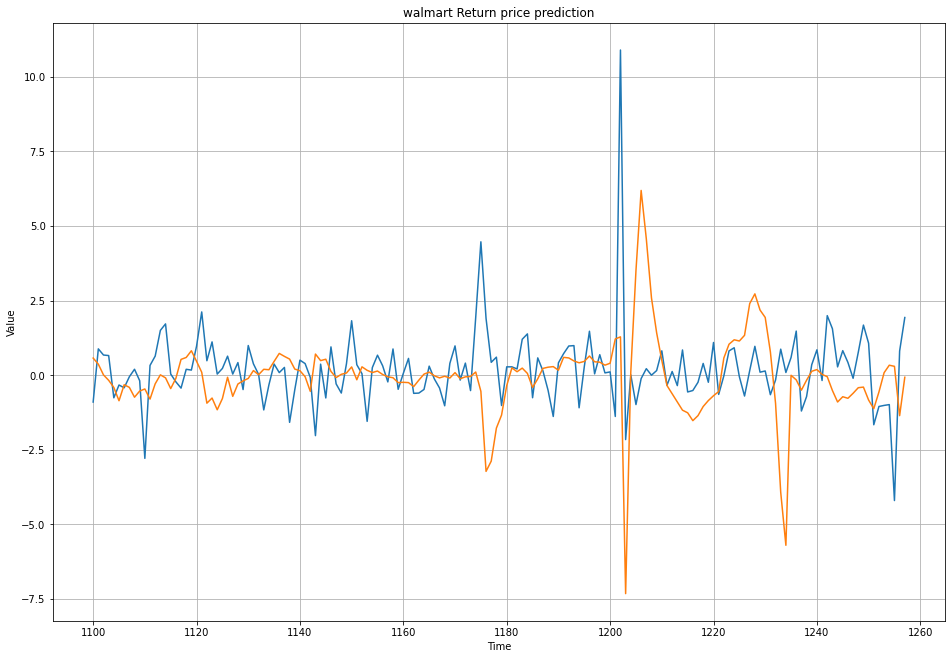

In [43]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(16, 11))
plt.title("walmart Return price prediction")
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [44]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

3.2570407

In [45]:
print("RMSE= " , math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()))

RMSE=  1.804727330944885


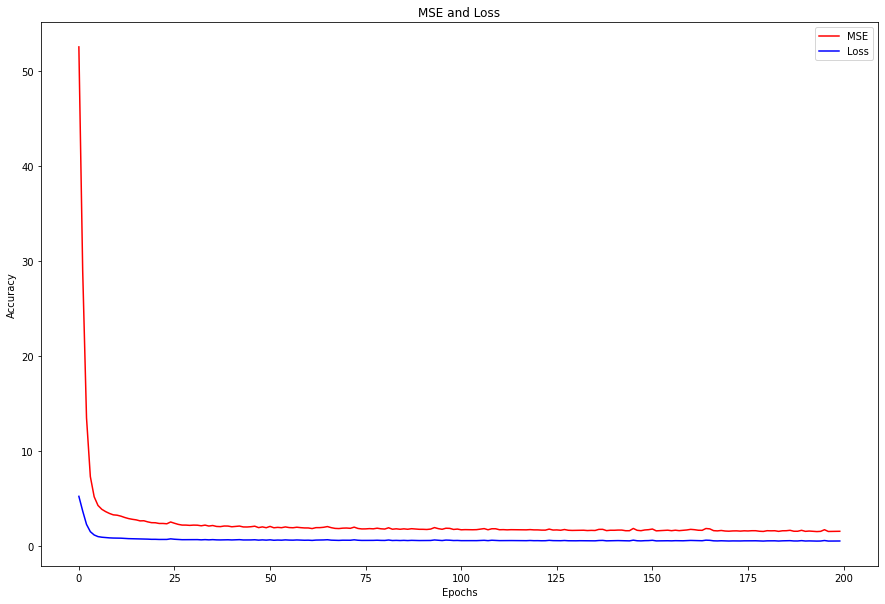

<Figure size 432x288 with 0 Axes>

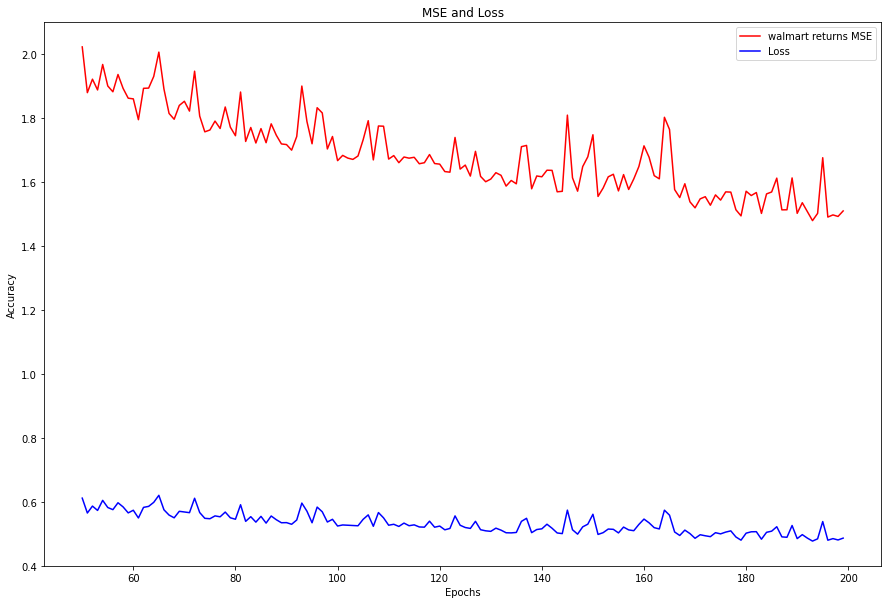

In [48]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:200]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["walmart returns MSE", "Loss"])

